Loaded 150 option rows.

Traditional models (MAE & RMSE)
                       MAE          RMSE
Model                                   
BlackScholes  3.721802e-10  1.622484e-09
Binomial      3.345500e-04  5.440726e-04
MonteCarlo    2.017243e-03  6.367415e-03
Heston        1.828011e+01  7.436075e+01
Merton        1.672222e+04  4.083643e+04
Bates         1.925638e+01  7.532368e+01

ML models (MAE & RMSE)
                       MAE      RMSE
Model                               
LinearRegression  0.001923  0.002607
RandomForest      0.000237  0.000428


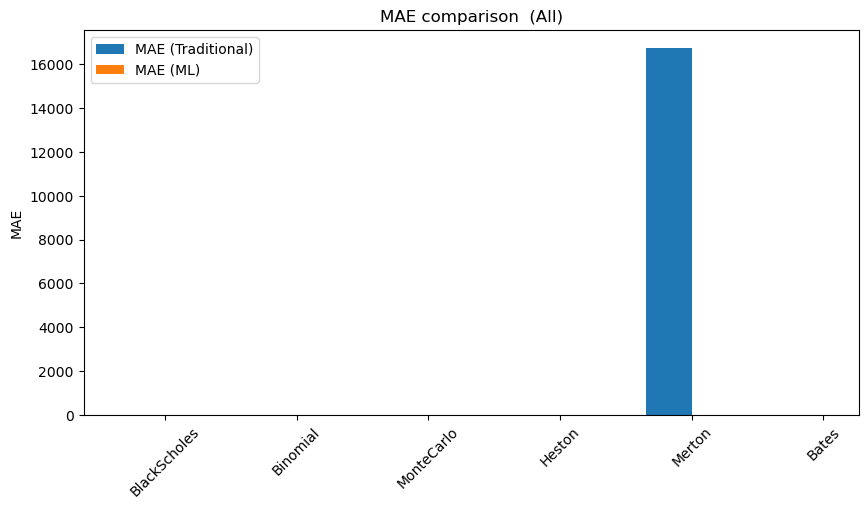

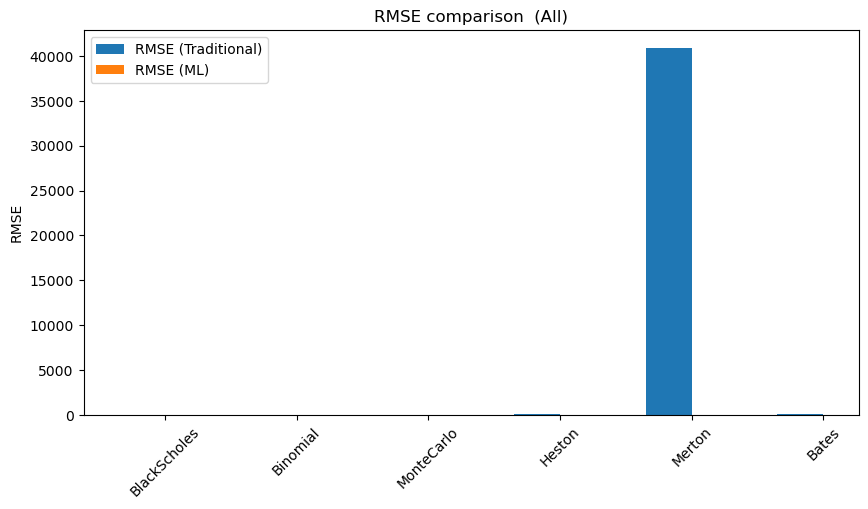

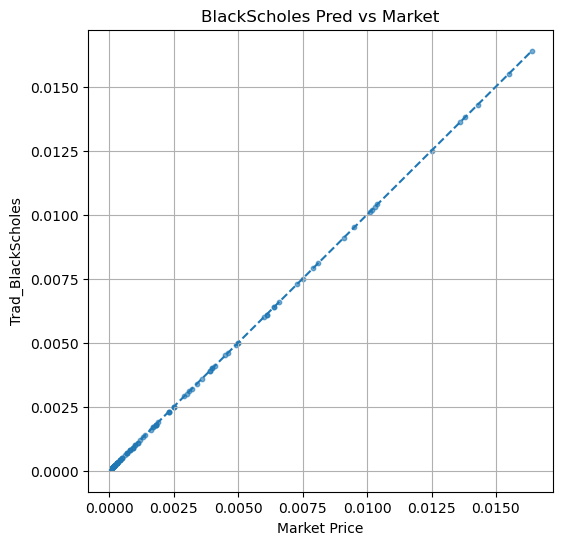

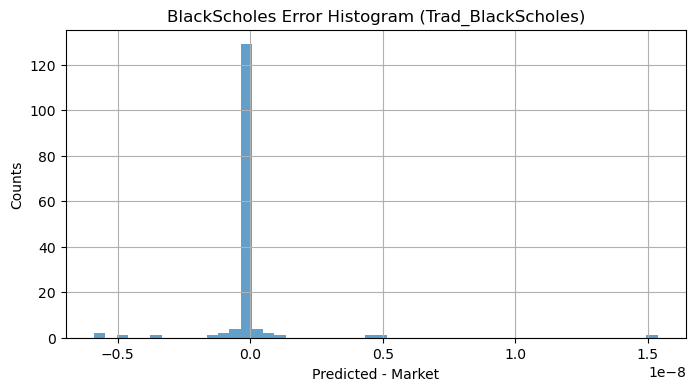

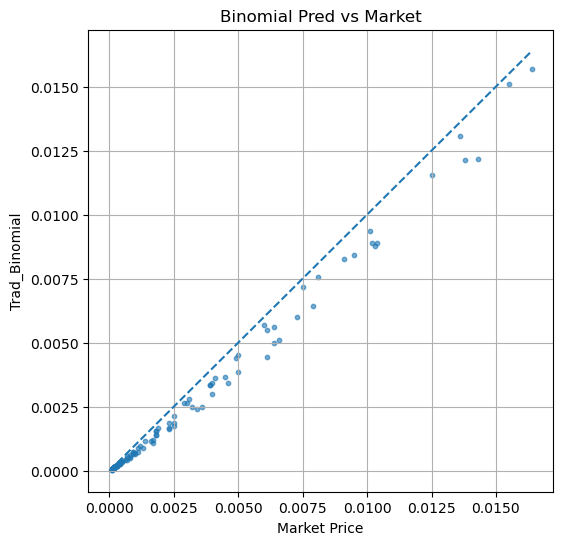

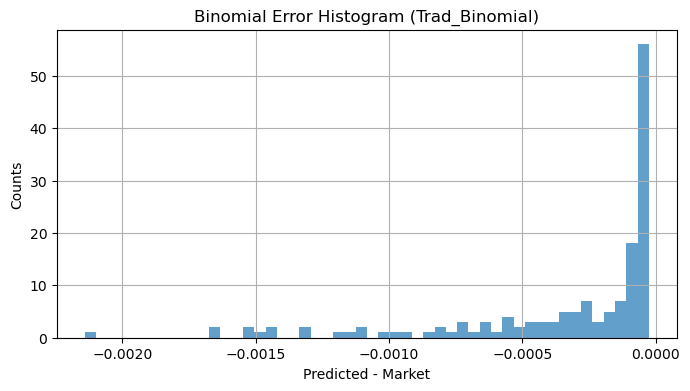

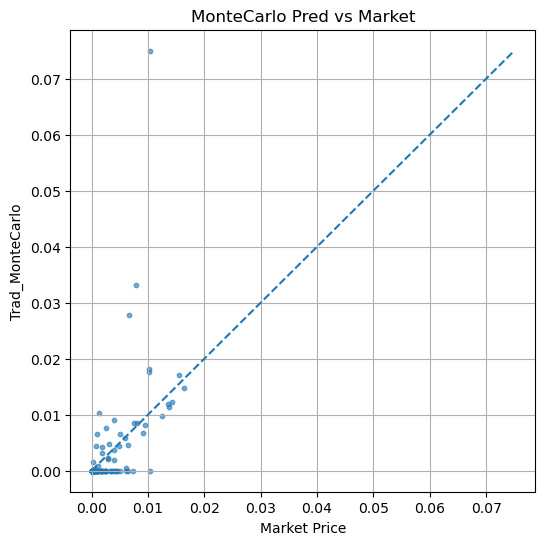

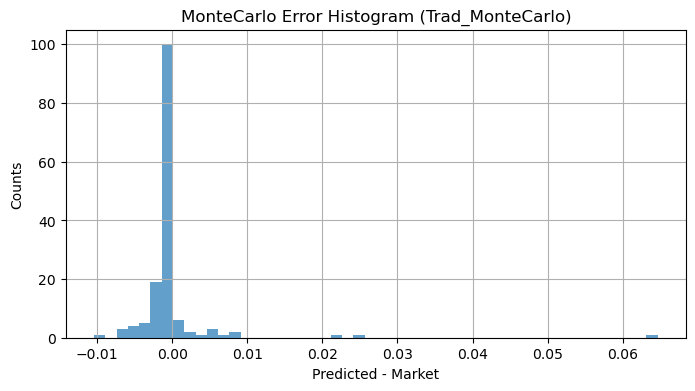

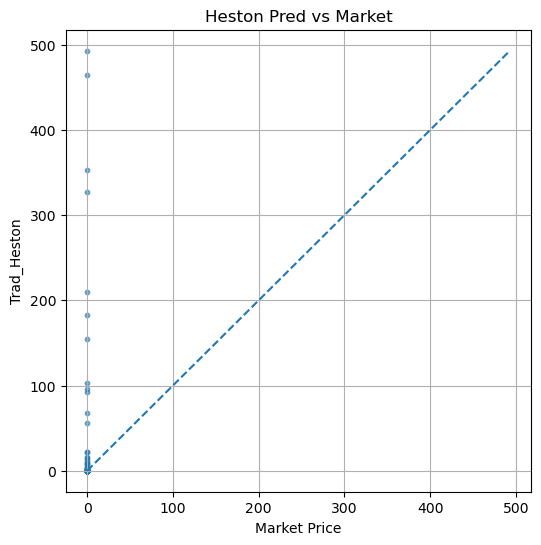

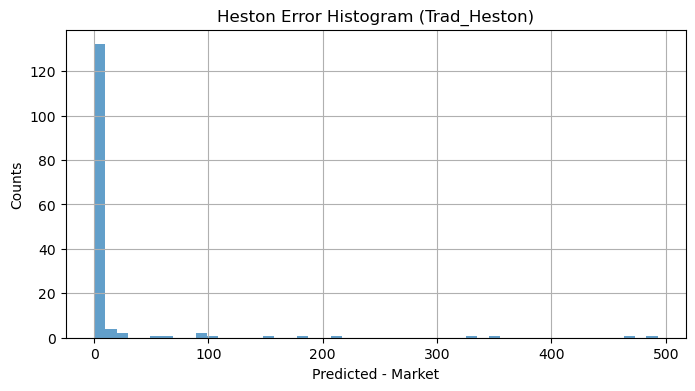

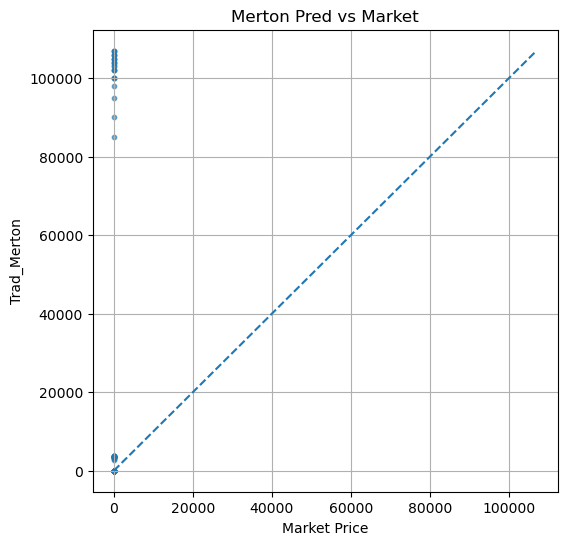

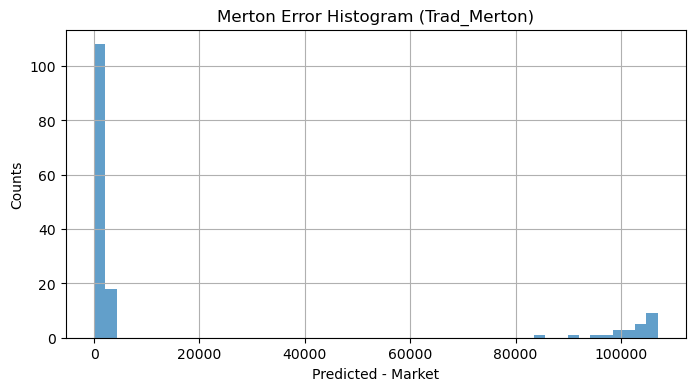

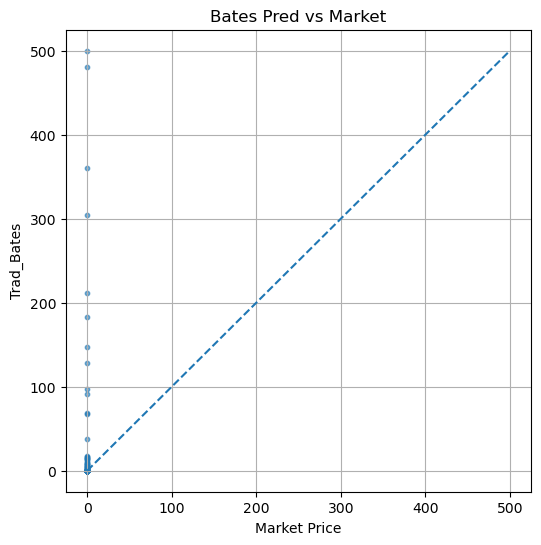

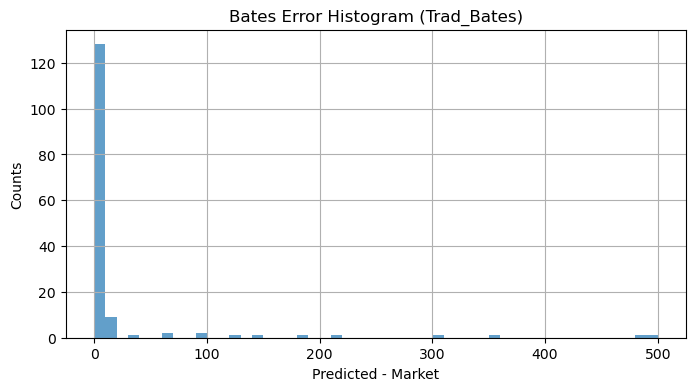

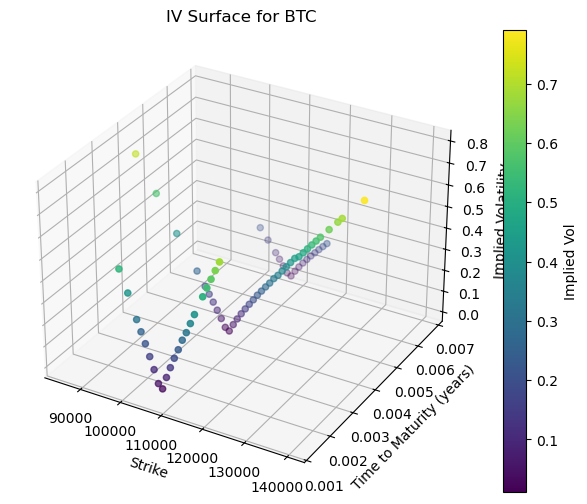

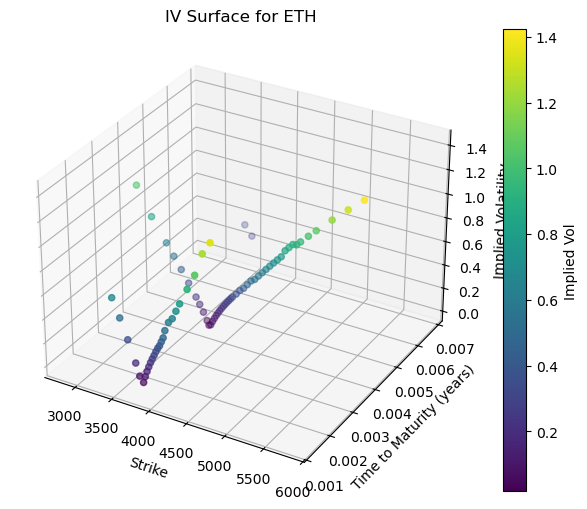

In [1]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timezone
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import math
import datetime as dt
from requests.adapters import HTTPAdapter, Retry

# ======== Utilities: requests session with retries ========
session = requests.Session()
retries = Retry(total=3, backoff_factor=0.5, status_forcelist=(429, 500, 502, 503, 504))
session.mount("https://", HTTPAdapter(max_retries=retries))

end = dt.datetime.now()
start = dt.datetime(2016,1,1)

# ========== Option pricing functions ==========

def bs_price(S, K, T, r, sigma, option_type='call'):
    if any(x is None for x in (S, K, T, r, sigma)):
        return np.nan
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan
    try:
        d1 = (np.log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
        if option_type.lower().startswith("c"):
            return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
        else:
            return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    except Exception:
        return np.nan

def implied_volatility(price, S, K, T, r, option_type='call', sigma_bounds=(1e-6, 5.0)):
    if any(x is None for x in (price, S, K, T, r)) or price <= 0 or S <= 0 or K <= 0 or T <= 0:
        return np.nan
    if option_type.lower().startswith("c"):
        intrinsic = max(0.0, S - K * math.exp(-r * T))
    else:
        intrinsic = max(0.0, K * math.exp(-r * T) - S)
    if price < intrinsic - 1e-12:
        return np.nan

    def f(sigma):
        return bs_price(S, K, T, r, sigma, option_type) - price

    a, b = sigma_bounds
    fa, fb = f(a), f(b)
    if np.isnan(fa) or np.isnan(fb):
        return np.nan

    try:
        if fa * fb > 0:
            for factor in [2, 5, 10]:
                new_b = min(b * factor, 100.0)
                fb = f(new_b)
                if fa * fb <= 0:
                    b = new_b
                    break
            else:
                return np.nan
        iv = brentq(f, a, b, xtol=1e-8, rtol=1e-8, maxiter=200)
        if iv <= 0 or iv > 100:
            return np.nan
        return iv
    except Exception:
        return np.nan

def binomial_option_price(S, K, T, r, sigma, option_type='call', steps=200):
    if any(x is None for x in (S, K, T, r, sigma)):
        return np.nan
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan
    dt = T / steps
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp(r * dt) - d) / (u - d)
    j = np.arange(steps + 1)
    ST = S * (u ** (steps - j)) * (d ** j)
    if option_type.lower().startswith('c'):
        payoffs = np.maximum(ST - K, 0.0)
    else:
        payoffs = np.maximum(K - ST, 0.0)
    for _ in range(steps):
        payoffs = disc * (p * payoffs[:-1] + (1 - p) * payoffs[1:])
    return float(payoffs[0])

def monte_carlo_option_price(S, K, T, r, sigma, option_type='call', simulations=20000, seed=None):
    if any(x is None for x in (S, K, T, r, sigma)):
        return np.nan
    if T <= 0 or sigma <= 0:
        return np.nan
    rng = np.random.default_rng(seed)
    ST = S * np.exp((r - 0.5 * sigma * sigma) * T + sigma * math.sqrt(T) * rng.standard_normal(simulations))
    if option_type.lower().startswith('c'):
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    return float(math.exp(-r * T) * np.mean(payoff))

# ========== Heston Monte Carlo (full-truncation Euler) ==========
def monte_carlo_heston(S0, K, T, r, kappa=2.0, theta=0.04, xi=0.5, rho=-0.7, v0=0.04,
                       option_type='call', simulations=5000, steps=200, seed=None):
    """
    Heston model Monte Carlo pricing using full-truncation Euler for variance.
    Returns discounted expected payoff.
    Params:
      S0 - spot
      K - strike
      T - time (years)
      r - risk free rate
      kappa - speed of mean reversion
      theta - long-run variance
      xi - vol-of-vol
      rho - correlation stock-var
      v0 - initial variance
    """
    if any(x is None for x in (S0, K, T, r)):
        return np.nan
    if T <= 0:
        return np.nan
    rng = np.random.default_rng(seed)
    dt = T / steps
    sqrt_dt = math.sqrt(dt)
    # initialize arrays
    S = np.full(simulations, S0, dtype=np.float64)
    v = np.full(simulations, v0, dtype=np.float64)
    # correlated normals via Cholesky
    for _ in range(steps):
        z1 = rng.standard_normal(simulations)
        z2 = rng.standard_normal(simulations)
        dw_v = z1 * sqrt_dt
        dw_s = (rho * z1 + math.sqrt(max(0.0, 1.0 - rho * rho)) * z2) * sqrt_dt
        # variance update (full-truncation Euler)
        v = np.maximum(v, 0.0)
        dv = kappa * (theta - np.maximum(v, 0.0)) * dt + xi * np.sqrt(np.maximum(v, 0.0)) * dw_v
        v = v + dv
        v = np.maximum(v, 0.0)  # ensure non-negative
        # stock update
        S = S * np.exp((r - 0.5 * np.maximum(v, 0.0)) * dt + np.sqrt(np.maximum(v, 0.0)) * dw_s)
    if option_type.lower().startswith('c'):
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
    return float(math.exp(-r * T) * np.mean(payoff))

# ========== Merton Jump-Diffusion Monte Carlo ==========
def monte_carlo_merton_jump(S0, K, T, r, sigma, lam=0.1, mu_j= -0.1, sigma_j=0.2,
                            option_type='call', simulations=5000, steps=200, seed=None):
    """
    Merton jump-diffusion: dS/S = (r - lambda*kappa_j - 0.5*sigma^2) dt + sigma dW + J dN
    where jumps J ~ lognormal with E[J]=exp(mu_j + 0.5*sigma_j^2) - 1,
    and kappa_j = E[J]
    """
    if any(x is None for x in (S0, K, T, r, sigma)):
        return np.nan
    if T <= 0:
        return np.nan
    rng = np.random.default_rng(seed)
    dt = T / steps
    S = np.full(simulations, S0, dtype=np.float64)
    # Precompute per-step expectation adjustment
    kappa_j = math.exp(mu_j + 0.5 * sigma_j * sigma_j) - 1.0
    drift_adj = r - lam * kappa_j - 0.5 * sigma * sigma
    for _ in range(steps):
        z = rng.standard_normal(simulations)
        # Poisson arrivals per path in dt
        N = rng.poisson(lam * dt, simulations)
        # sum of jumps for those with N>0
        jumps = np.zeros(simulations, dtype=np.float64)
        # For paths with N>0, sample sum of N lognormal multiplicative jumps
        idx = np.nonzero(N)[0]
        if idx.size > 0:
            # For each path, generate N_i normal sums
            # Rather than looping path-by-path, sample maximum and trim, but for clarity do a small loop
            for i in idx:
                Ni = int(N[i])
                # sum of lognormal multiplicative factors -> multiplicative factor = product(exp(mu_j + sigma_j * Z_k))
                zk = rng.standard_normal(Ni)
                jumps[i] = np.prod(np.exp(mu_j + sigma_j * zk))
        # Update S
        S = S * np.exp(drift_adj * dt + sigma * math.sqrt(dt) * z) * jumps
    if option_type.lower().startswith('c'):
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
    return float(math.exp(-r * T) * np.mean(payoff))


# =========================
# Heston & Jump Diffusion Extensions
# =========================

def heston_monte_carlo_option_price(S, K, T, r, v0, kappa, theta, sigma_v, rho, option_type='call', simulations=10000, steps=100):
    """
    Monte Carlo simulation for Heston model.
    v_t follows CIR process: dv = kappa*(theta - v)*dt + sigma_v*sqrt(v)*dW2
    Correlation between dW1 and dW2 = rho
    """
    dt = T / steps
    rng = np.random.default_rng()
    S_paths = np.zeros((simulations, steps + 1))
    v_paths = np.zeros((simulations, steps + 1))
    S_paths[:, 0] = S
    v_paths[:, 0] = v0

    for t in range(steps):
        Z1 = rng.standard_normal(simulations)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * rng.standard_normal(simulations)

        v_paths[:, t + 1] = np.maximum(
            v_paths[:, t] + kappa * (theta - v_paths[:, t]) * dt + sigma_v * np.sqrt(np.maximum(v_paths[:, t], 0)) * np.sqrt(dt) * Z2,
            0
        )
        S_paths[:, t + 1] = S_paths[:, t] * np.exp(
            (r - 0.5 * v_paths[:, t]) * dt + np.sqrt(np.maximum(v_paths[:, t], 0)) * np.sqrt(dt) * Z1
        )

    ST = S_paths[:, -1]
    if option_type.lower().startswith('c'):
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)

    return np.exp(-r * T) * np.mean(payoff)


def jump_diffusion_option_price(S, K, T, r, sigma, lam, muJ, sigmaJ, option_type='call', simulations=10000):
    """
    Merton Jump Diffusion Monte Carlo.
    dS/S = (r - 0.5*sigma^2 - λ*k)*dt + σ*dW + J*dN
    J ~ logN(muJ, sigmaJ^2), N ~ Poisson(λT)
    """
    rng = np.random.default_rng()
    k = np.exp(muJ + 0.5 * sigmaJ**2) - 1
    ST = np.zeros(simulations)
    for i in range(simulations):
        Nj = rng.poisson(lam * T)
        jump_sum = np.sum(rng.normal(muJ, sigmaJ, Nj)) if Nj > 0 else 0
        ST[i] = S * np.exp((r - 0.5 * sigma**2 - lam * k) * T +
                           sigma * np.sqrt(T) * rng.standard_normal() + jump_sum)

    if option_type.lower().startswith('c'):
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)

    return np.exp(-r * T) * np.mean(payoff)


# ========== Bates: Heston + Jumps ==========
def monte_carlo_bates(S0, K, T, r,
                      kappa=2.0, theta=0.04, xi=0.5, rho=-0.7, v0=0.04,
                      lam=0.1, mu_j=-0.1, sigma_j=0.2,
                      option_type='call', simulations=4000, steps=200, seed=None):
    """
    Bates model Monte Carlo: Heston stochastic vol + Poisson lognormal jumps
    """
    if any(x is None for x in (S0, K, T, r)):
        return np.nan
    if T <= 0:
        return np.nan
    rng = np.random.default_rng(seed)
    dt = T / steps
    S = np.full(simulations, S0, dtype=np.float64)
    v = np.full(simulations, v0, dtype=np.float64)
    kappa_j = math.exp(mu_j + 0.5 * sigma_j * sigma_j) - 1.0
    for _ in range(steps):
        z1 = rng.standard_normal(simulations)
        z2 = rng.standard_normal(simulations)
        dw_v = z1 * math.sqrt(dt)
        dw_s = (rho * z1 + math.sqrt(max(0.0, 1.0 - rho * rho)) * z2) * math.sqrt(dt)
        # Heston variance update (full truncation)
        v = np.maximum(v, 0.0)
        dv = kappa * (theta - np.maximum(v, 0.0)) * dt + xi * np.sqrt(np.maximum(v, 0.0)) * dw_v
        v = v + dv
        v = np.maximum(v, 0.0)
        # Jumps
        N = rng.poisson(lam * dt, simulations)
        jumps = np.ones(simulations, dtype=np.float64)
        idx = np.nonzero(N)[0]
        if idx.size > 0:
            for i in idx:
                Ni = int(N[i])
                zk = rng.standard_normal(Ni)
                jumps[i] = np.prod(np.exp(mu_j + sigma_j * zk))
        # Adjust drift for jump compensator
        drift_adj = r - lam * kappa_j - 0.5 * np.maximum(v, 0.0)
        S = S * np.exp(drift_adj * dt + np.sqrt(np.maximum(v, 0.0)) * dw_s) * jumps
    if option_type.lower().startswith('c'):
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
    return float(math.exp(-r * T) * np.mean(payoff))

# ========== Simple cache for expensive pricing calls ==========
_price_cache = {}
def cached_price(func, *args, **kwargs):
    key = (func.__name__,) + tuple(args) + tuple(sorted(kwargs.items()))
    if key in _price_cache:
        return _price_cache[key]
    val = func(*args, **kwargs)
    _price_cache[key] = val
    return val

# ========== Deribit API helpers (safer) ==========
DERIBIT_URL = "https://www.deribit.com/api/v2/public"


def safe_json_request(url, params=None, timeout=10):
    try:
        resp = session.get(url, params=params, timeout=timeout)
        resp.raise_for_status()
        return resp.json()
    except Exception:
        return {}

def get_index_price(currency="BTC"):
    url = f"{DERIBIT_URL}/get_index"
    data = safe_json_request(url, params={"currency": currency})
    result = data.get("result") or {}
    for possible in (currency, "index_price", "price"):
        if possible in result and isinstance(result[possible], (int, float)):
            return float(result[possible])
    for v in result.values():
        if isinstance(v, (int, float)):
            return float(v)
    return np.nan

def get_option_instruments(currency="BTC"):
    url = f"{DERIBIT_URL}/get_instruments"
    data = safe_json_request(url, params={"currency": currency, "kind": "option", "expired": "false"})
    return data.get("result", []) or []

def get_option_ticker(instrument_name):
    url = f"{DERIBIT_URL}/ticker"
    data = safe_json_request(url, params={"instrument_name": instrument_name})
    return data.get("result", {}) or {}

# ========== Fetch options data with better error handling and caching ==========
def fetch_options_data(currency="BTC", r=0.02, max_insts=200, sleep_between=0.08):
    instruments = get_option_instruments(currency)
    if not instruments:
        return pd.DataFrame()
    spot = get_index_price(currency)
    rows = []
    for inst in instruments[:max_insts]:
        try:
            name = inst.get("instrument_name")
            strike = inst.get("strike")
            exp_ts = inst.get("expiration_timestamp")
            if None in (name, strike, exp_ts):
                continue
            exp_ts = exp_ts / 1000.0
            T = (datetime.fromtimestamp(exp_ts, tz=timezone.utc) - datetime.now(timezone.utc)).total_seconds() / (365.0*24*3600)
            if T <= 0:
                continue
            tick = get_option_ticker(name)
            mark = tick.get("mark_price") or tick.get("last_price") or tick.get("best_bid_price") or tick.get("best_ask_price")
            if mark is None or mark <= 0 or np.isnan(spot):
                continue
            opt_type = inst.get("option_type")
            iv = implied_volatility(mark, spot, strike, T, r, opt_type)
            rows.append({
                "currency": currency,
                "instrument": name,
                "underlying_price": float(spot),
                "strike": float(strike),
                "time_to_maturity": float(T),
                "risk_free_rate": float(r),
                "implied_volatility": float(iv) if not np.isnan(iv) else np.nan,
                "market_price": float(mark),
                "option_type": opt_type
            })
        except Exception:
            continue
        time.sleep(sleep_between)
    return pd.DataFrame(rows)

# ========== Add traditional models with caching (extended) ==========
def add_traditional_models(df,
                           mc_sims_standard=10000,
                           mc_sims_heston=5000,
                           mc_sims_merton=5000,
                           mc_sims_bates=4000,
                           mc_steps=200):
    df = df.copy()
    df[['underlying_price', 'strike', 'time_to_maturity', 'risk_free_rate', 'implied_volatility']] = \
        df[['underlying_price', 'strike', 'time_to_maturity', 'risk_free_rate', 'implied_volatility']].apply(pd.to_numeric, errors='coerce')

    df["BS_price"] = df.apply(lambda r: bs_price(r["underlying_price"], r["strike"], r["time_to_maturity"], r["risk_free_rate"], r["implied_volatility"], r["option_type"]), axis=1)
    df["Binomial_price"] = df.apply(lambda r: cached_price(binomial_option_price, r["underlying_price"], r["strike"], r["time_to_maturity"], r["risk_free_rate"], r["implied_volatility"], r["option_type"], 100), axis=1)
    df["MonteCarlo_price"] = df.apply(lambda r: cached_price(monte_carlo_option_price, r["underlying_price"], r["strike"], r["time_to_maturity"], r["risk_free_rate"], r["implied_volatility"], r["option_type"], mc_sims_standard, None), axis=1)

    # Heston default params (these are placeholders; calibrate for accurate results)
    def heston_row(r):
        return cached_price(monte_carlo_heston,
                            r["underlying_price"], r["strike"], r["time_to_maturity"], r["risk_free_rate"],
                            2.0, 0.04, 0.5, -0.7, 0.04,
                            r["option_type"], mc_sims_heston, mc_steps, None)
    df["Heston_price"] = df.apply(lambda r: heston_row(r), axis=1)

    # Merton jump-diffusion params (lam, mu_j, sigma_j) placeholders
    def merton_row(r):
        return cached_price(monte_carlo_merton_jump,
                            r["underlying_price"], r["strike"], r["time_to_maturity"], r["risk_free_rate"], r["implied_volatility"],
                            0.1, -0.05, 0.2, r["option_type"], mc_sims_merton, mc_steps, None)
    df["Merton_price"] = df.apply(lambda r: merton_row(r), axis=1)

    # Bates (Heston + jumps)
    def bates_row(r):
        return cached_price(monte_carlo_bates,
                            r["underlying_price"], r["strike"], r["time_to_maturity"], r["risk_free_rate"],
                            2.0, 0.04, 0.5, -0.7, 0.04,
                            0.08, -0.05, 0.25, r["option_type"], mc_sims_bates, mc_steps, None)
    df["Bates_price"] = df.apply(lambda r: bates_row(r), axis=1)

    return df

# ========== ML helpers ==========
def train_ml_models(df):
    dfc = df.copy()
    features = ["underlying_price", "strike", "time_to_maturity", "risk_free_rate", "implied_volatility"]
    dfc = dfc.dropna(subset=features + ["market_price"])
    if len(dfc) < 10:
        return {}
    X = dfc[features].values
    y = dfc["market_price"].values
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=0)
    }
    preds = {}
    for name, m in models.items():
        m.fit(X, y)
        preds[name] = m.predict(df[features].fillna(dfc[features].mean()).values)
    return preds

def evaluate_models(df, preds_dict, label_prefix):
    metrics = {}
    for name, preds in preds_dict.items():
        col_name = f"{label_prefix}_{name}"
        df[col_name] = preds
        tmp = df[["market_price", col_name]].dropna()
        if tmp.empty:
            metrics[name] = {"MAE": np.nan, "RMSE": np.nan}
            continue
        mae = mean_absolute_error(tmp["market_price"], tmp[col_name])
        rmse = np.sqrt(mean_squared_error(tmp["market_price"], tmp[col_name]))
        metrics[name] = {"MAE": float(mae), "RMSE": float(rmse)}
    return metrics

# ========== Additional evaluation & plotting helpers ==========
def print_metrics_table(metrics_dict, title="Model metrics"):
    print("\n" + title)
    rows = []
    for name, m in metrics_dict.items():
        rows.append((name, m.get("MAE", np.nan), m.get("RMSE", np.nan)))
    tab = pd.DataFrame(rows, columns=["Model", "MAE", "RMSE"]).set_index("Model")
    print(tab)
    return tab

def plot_pred_vs_market(df, pred_col, title="Predicted vs Market"):
    tmp = df.dropna(subset=[pred_col, "market_price"])
    if tmp.empty:
        print("No data for", pred_col)
        return
    plt.figure(figsize=(6,6))
    plt.scatter(tmp["market_price"], tmp[pred_col], alpha=0.6, s=10)
    mx = np.nanmax([tmp["market_price"].max(), tmp[pred_col].max()])
    plt.plot([0, mx], [0, mx], linestyle='--')
    plt.xlabel("Market Price")
    plt.ylabel(pred_col)
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_error_histograms(df, pred_col, title="Pricing Error Histogram"):
    tmp = df.dropna(subset=[pred_col, "market_price"])
    if tmp.empty:
        print("No data for", pred_col)
        return
    errors = tmp[pred_col] - tmp["market_price"]
    plt.figure(figsize=(8,4))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title(title + " (" + pred_col + ")")
    plt.xlabel("Predicted - Market")
    plt.ylabel("Counts")
    plt.grid(True)
    plt.show()

def plot_error_metrics(metrics_trad, metrics_ml, title_suffix=""):
    models = list(metrics_trad.keys())
    mae_trad = [metrics_trad[m]["MAE"] for m in models]
    mae_ml = [metrics_ml.get(m, {"MAE": np.nan})["MAE"] for m in models]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, mae_trad, width, label='MAE (Traditional)')
    ax.bar(x + width/2, mae_ml, width, label='MAE (ML)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel("MAE")
    ax.set_title("MAE comparison " + title_suffix)
    ax.legend()
    plt.show()

    rmse_trad = [metrics_trad[m]["RMSE"] for m in models]
    rmse_ml = [metrics_ml.get(m, {"RMSE": np.nan})["RMSE"] for m in models]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, rmse_trad, width, label='RMSE (Traditional)')
    ax.bar(x + width/2, rmse_ml, width, label='RMSE (ML)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel("RMSE")
    ax.set_title("RMSE comparison " + title_suffix)
    ax.legend()
    plt.show()

def plot_iv_surface(df, currency, annotate=False):
    d = df.dropna(subset=["implied_volatility", "strike", "time_to_maturity"])
    if d.empty:
        print("No IV data to plot for", currency)
        return
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    xs = d["strike"].values
    ys = d["time_to_maturity"].values
    zs = d["implied_volatility"].values
    sc = ax.scatter(xs, ys, zs, c=zs, cmap="viridis")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Time to Maturity (years)")
    ax.set_zlabel("Implied Volatility")
    ax.set_title(f"IV Surface for {currency}")
    fig.colorbar(sc, label="Implied Vol")
    plt.show()

# ========== Main workflow (keeps your original flow, but extended) ==========
def main():
    btc = fetch_options_data("BTC", max_insts=150)
    eth = fetch_options_data("ETH", max_insts=150)
    if btc.empty and eth.empty:
        print("No data fetched from exchanges. Check network/API or increase max_insts.")
        return
    df = pd.concat([btc, eth], ignore_index=True)
    df = df.dropna(subset=["underlying_price", "strike", "time_to_maturity", "implied_volatility", "market_price"])
    print(f"Loaded {len(df)} option rows.")

    # Add traditional + extended models (Heston, Merton, Bates)
    df = add_traditional_models(df,
                                mc_sims_standard=8000,
                                mc_sims_heston=4000,
                                mc_sims_merton=4000,
                                mc_sims_bates=3000,
                                mc_steps=150)

    # Collect predictions
    preds_trad = {
        "BlackScholes": df["BS_price"].values,
        "Binomial": df["Binomial_price"].values,
        "MonteCarlo": df["MonteCarlo_price"].values,
        "Heston": df["Heston_price"].values,
        "Merton": df["Merton_price"].values,
        "Bates": df["Bates_price"].values
    }
    # Evaluate traditional
    metrics_trad = evaluate_models(df, preds_trad, label_prefix="Trad")

    # ML
    preds_ml = train_ml_models(df)
    metrics_ml = evaluate_models(df, preds_ml, label_prefix="ML") if preds_ml else {}

    print_metrics_table(metrics_trad, title="Traditional models (MAE & RMSE)")
    print_metrics_table(metrics_ml, title="ML models (MAE & RMSE)")

    # Visual comparisons
    plot_error_metrics(metrics_trad, metrics_ml, title_suffix=" (All)")

    # For each model, scatter plot vs market and error histogram
    for m in preds_trad.keys():
        col = f"Trad_{m}"
        df[col] = preds_trad[m]
        plot_pred_vs_market(df, col, title=f"{m} Pred vs Market")
        plot_error_histograms(df, col, title=f"{m} Error Histogram")

    for c in df["currency"].unique():
        sub = df[df["currency"] == c]
        plot_iv_surface(sub, c)

if __name__ == "__main__":
    main()


Loaded 1588 option rows (calls+puts total).


C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:403: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['gas_fee_gwei'] = df['gas_fee_gwei'].fillna(method='ffill').fillna(np.nan)
C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:404: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['btc_fee_sat_per_byte'] = df['btc_fee_sat_per_byte'].fillna(method='ffill').fillna(np.nan)



🔨 [add_feature_engineering] Creating advanced features...
✅ Feature engineering complete.

Overall Metrics (Full Dataset)
                       MAE          RMSE
Model                                   
BlackScholes  1.825300e-08  3.375073e-07
Binomial      4.633888e-03  1.220390e-02
MonteCarlo    2.152792e-02  4.701434e-02
Heston        9.895108e+03  3.227875e+04
Merton        1.013153e+02  3.104729e+02
Bates         9.928104e+03  3.228627e+04

BlackScholes group breakdown (currency x option_type):
                               MAE          RMSE
currency option_type                            
BTC      call         4.917989e-08  5.959496e-07
         put          5.847431e-09  2.037909e-08
ETH      call         1.967539e-09  6.958446e-09
         put          5.440452e-09  3.576743e-08

Binomial group breakdown (currency x option_type):
                           MAE      RMSE
currency option_type                    
BTC      call         0.007056  0.019820
         put          0.

C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:634: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(['currency','option_type']).apply(lambda g: pd.Series({'MAE': mean_absolute_error(g['market_price'], g[col]), 'RMSE': np.sqrt(mean_squared_error(g['market_price'], g[col]))})) if not tmp.empty else pd.DataFrame()
C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:634: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping column

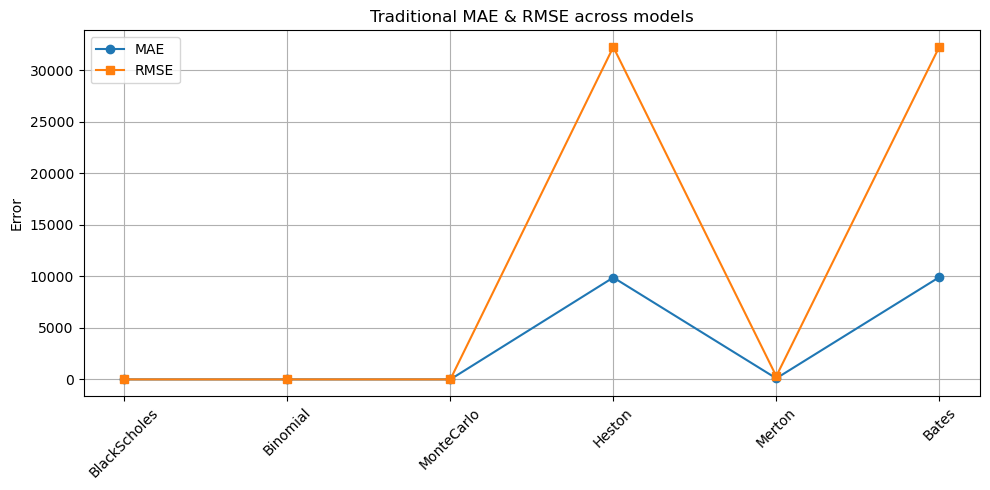


🔧 [train_ml_models] Starting model training...
✅ Using features: ['underlying_price', 'strike', 'time_to_maturity', 'risk_free_rate', 'implied_volatility', 'option_type_is_call', 'moneyness', 'sqrt_time_to_maturity', 'bs_delta', 'bs_vega', 'is_atm', 'is_itm', 'is_otm', 'gas_fee_gwei', 'btc_fee_sat_per_byte', 'BS_price']
🎯 Target: market_price
✅ Imputation complete: X shape=(1588, 15), y length=1588
🚀 Training LinearRegression ...
   → LinearRegression done. MAE=0.1801, RMSE=0.2871
🚀 Training RandomForest ...


C:\Users\Wale\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['gas_fee_gwei']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\Wale\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Wale\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['gas_fee_gwei']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\Wale\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  war

   → RandomForest done. MAE=0.0060, RMSE=0.0122

📊 ML model performance on Test Set:
                       MAE      RMSE
LinearRegression  0.180054  0.287103
RandomForest      0.006011  0.012178

Overall Metrics (Full Dataset)
                       MAE      RMSE
Model                               
LinearRegression  0.171136  0.272613
RandomForest      0.003156  0.008089

LinearRegression group breakdown (currency x option_type):
                           MAE      RMSE
currency option_type                    
BTC      call         0.159105  0.219098
         put          0.192094  0.279930
ETH      call         0.123487  0.170164
         put          0.210756  0.373782

RandomForest group breakdown (currency x option_type):
                           MAE      RMSE
currency option_type                    
BTC      call         0.001558  0.003838
         put          0.004573  0.010952
ETH      call         0.002127  0.005325
         put          0.004349  0.009952


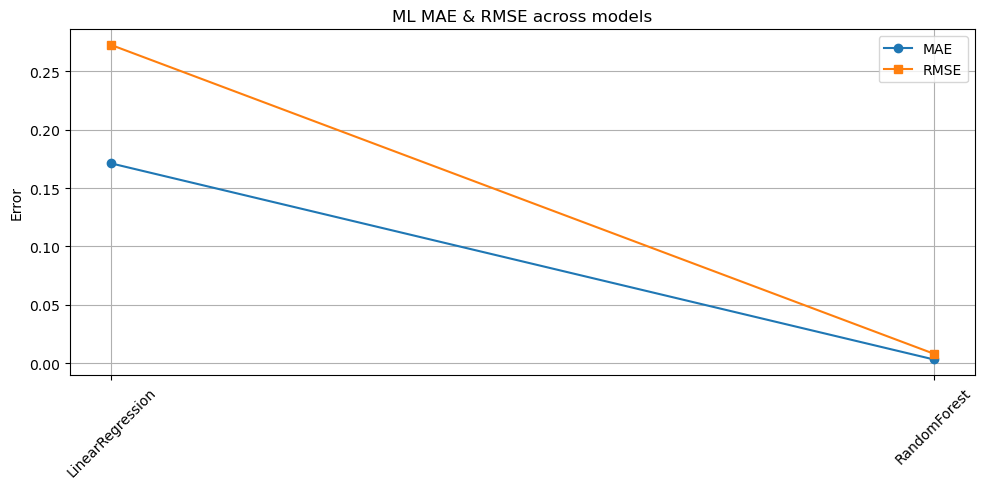

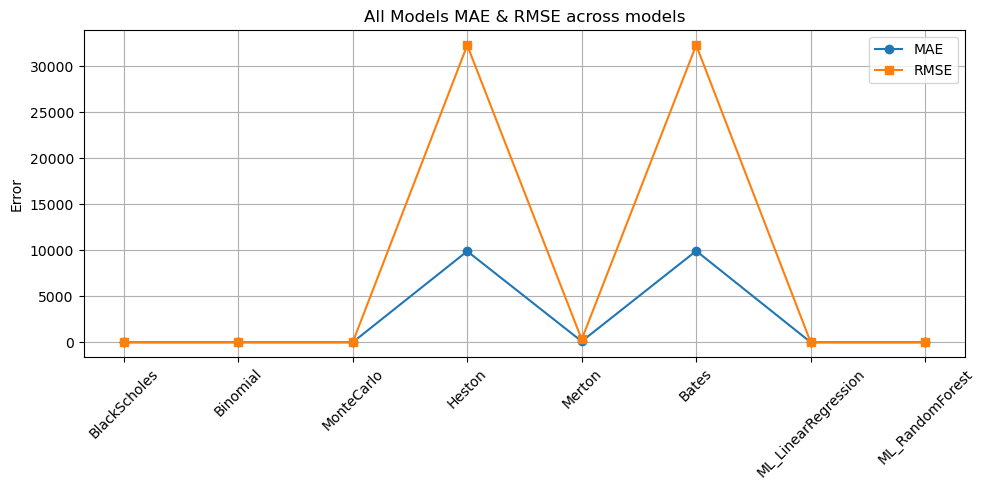

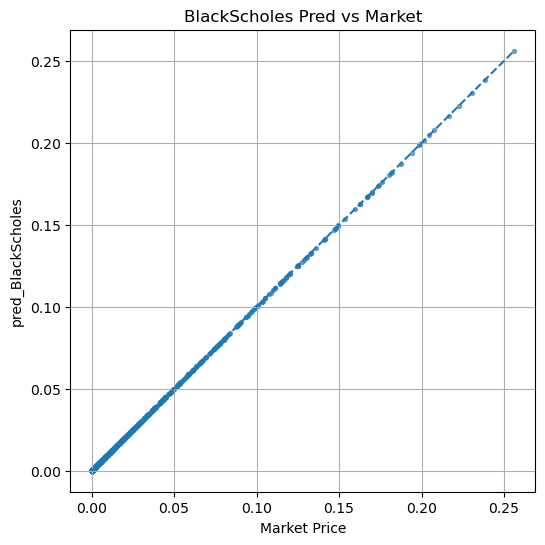

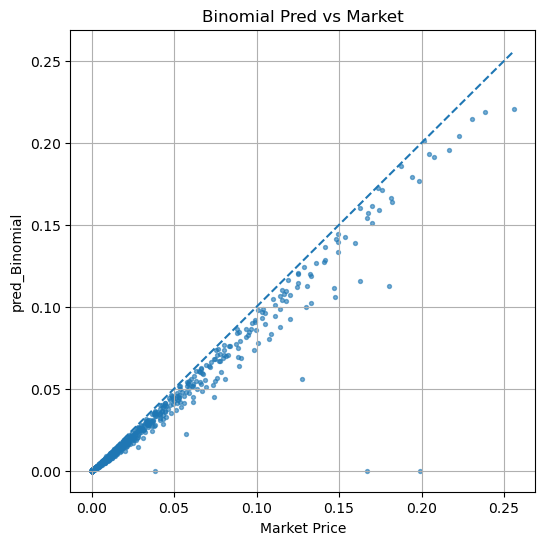

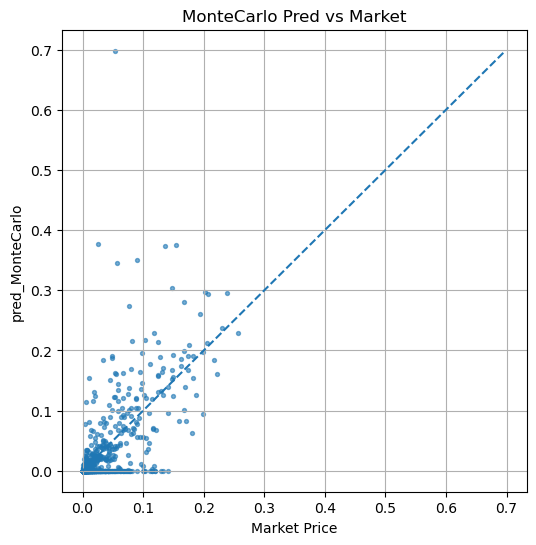

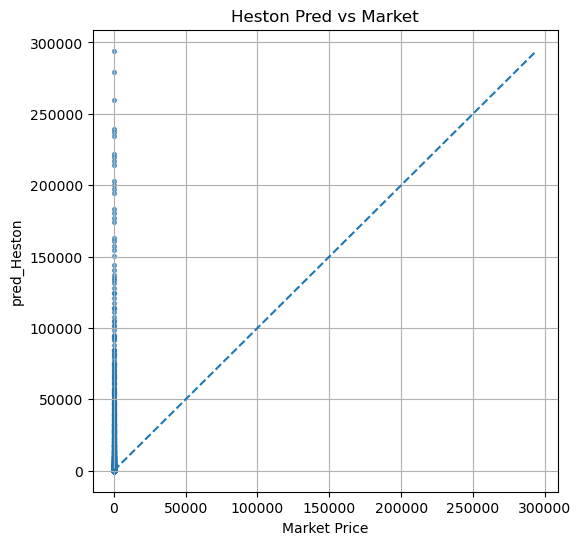

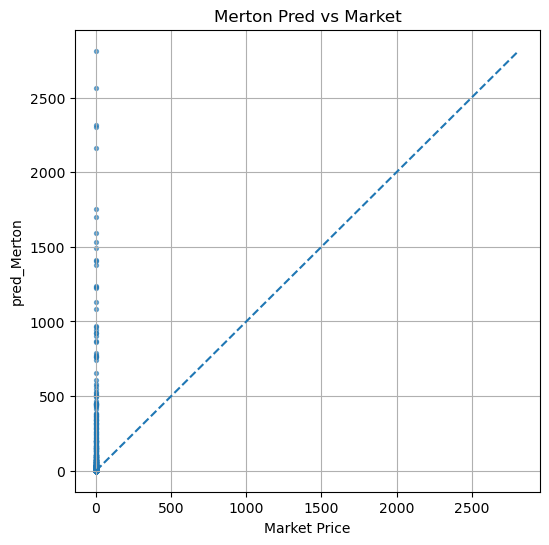

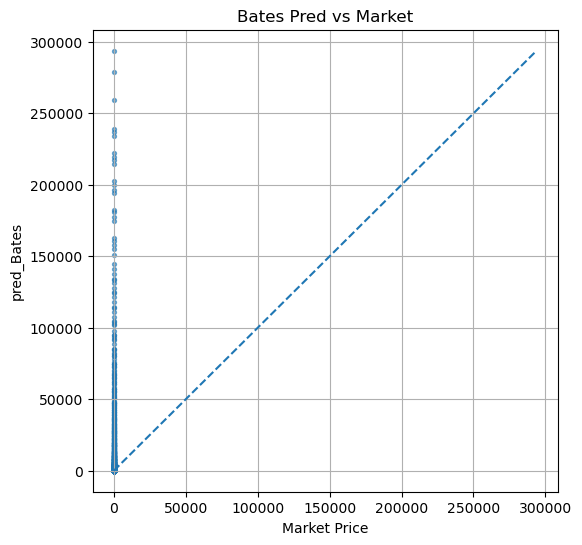

C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:685: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['error'] = tmp[col] - tmp['market_price']


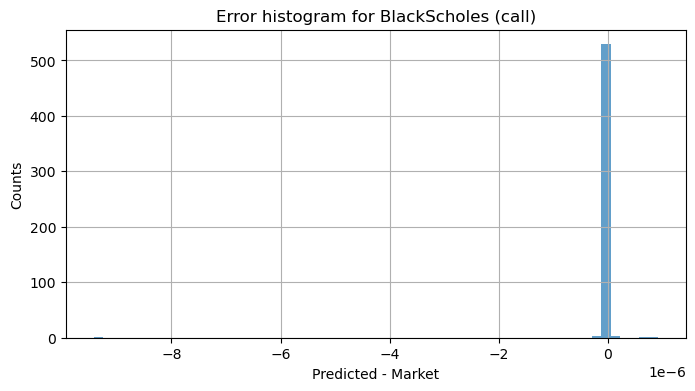

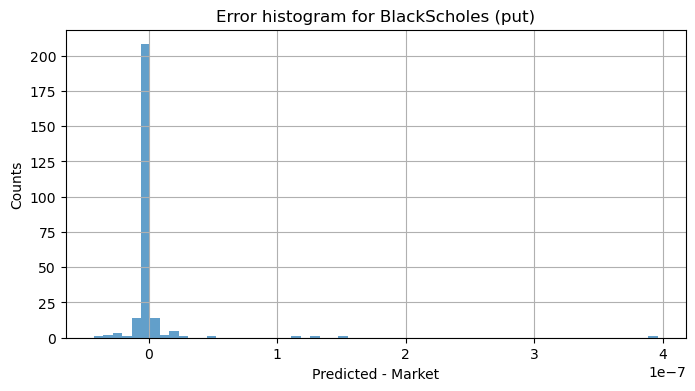

C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:685: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['error'] = tmp[col] - tmp['market_price']


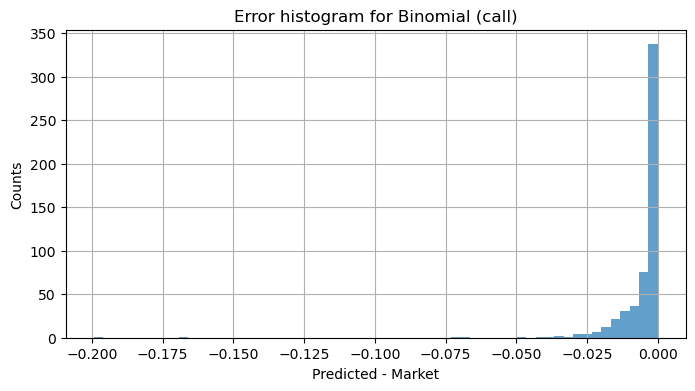

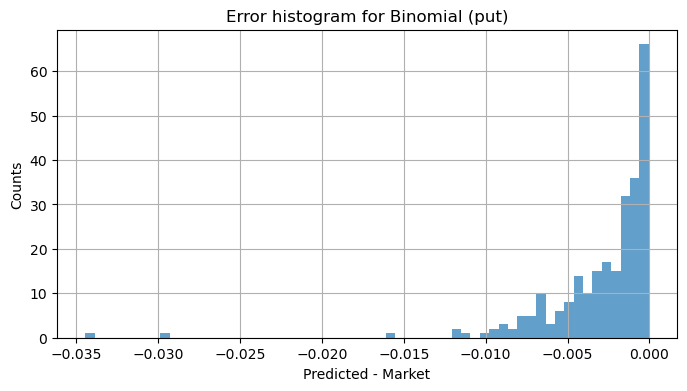

C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:685: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['error'] = tmp[col] - tmp['market_price']


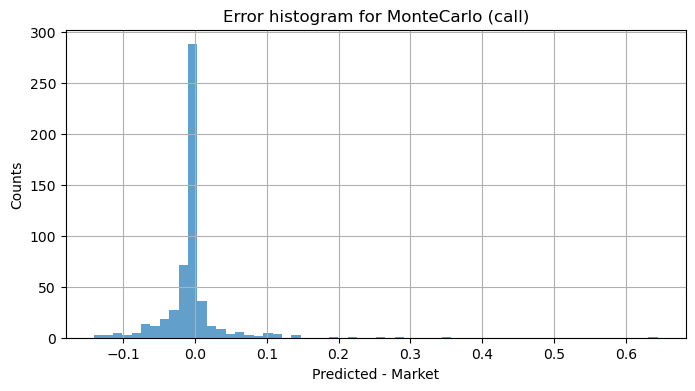

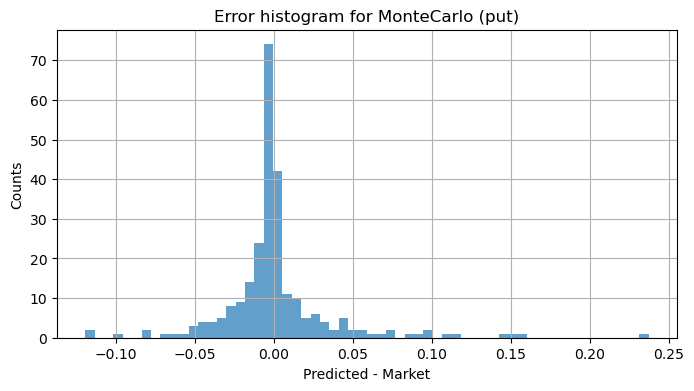

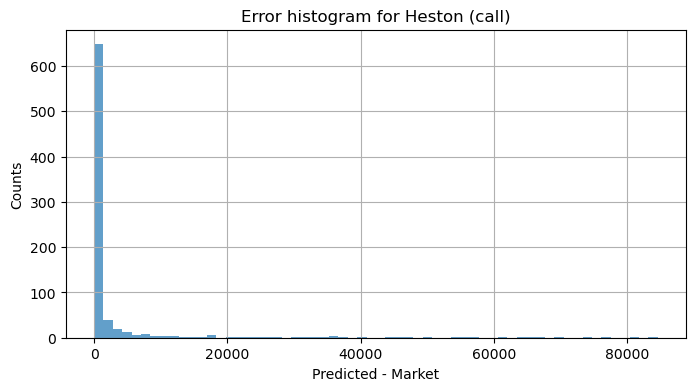

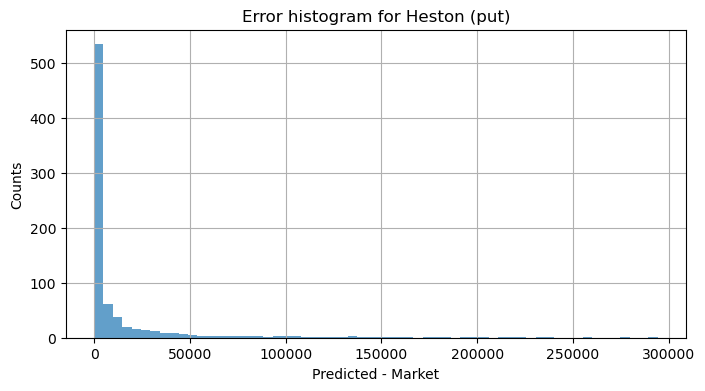

C:\Users\Wale\AppData\Local\Temp\ipykernel_14904\2654034265.py:685: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['error'] = tmp[col] - tmp['market_price']


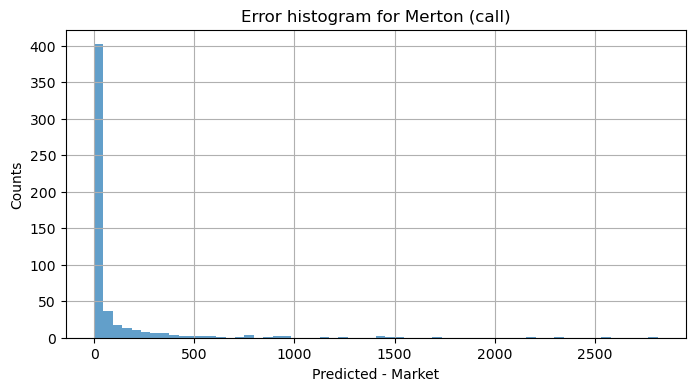

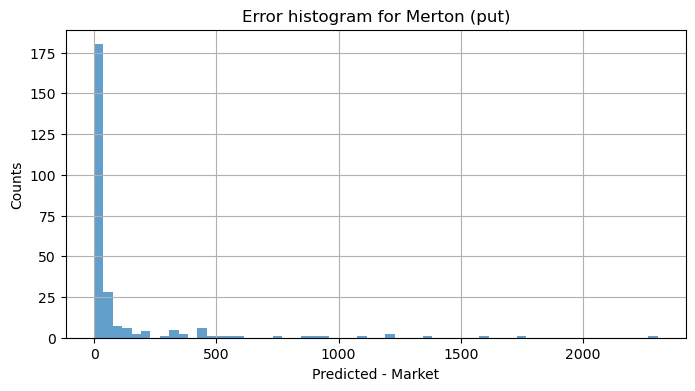

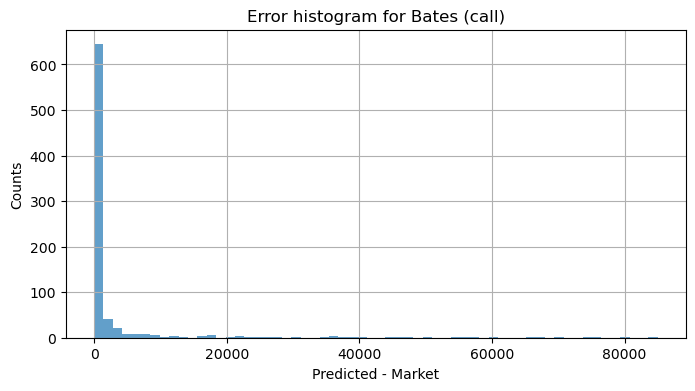

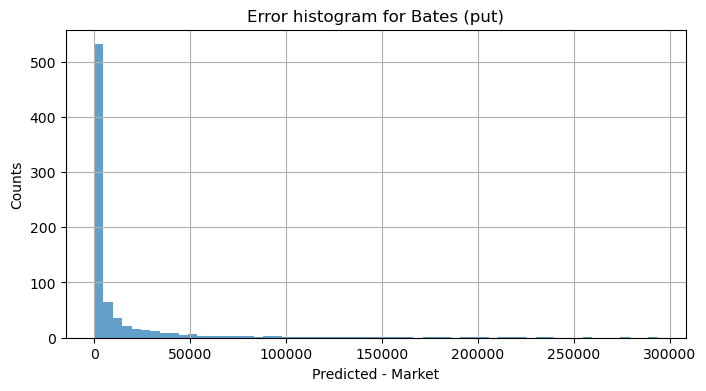

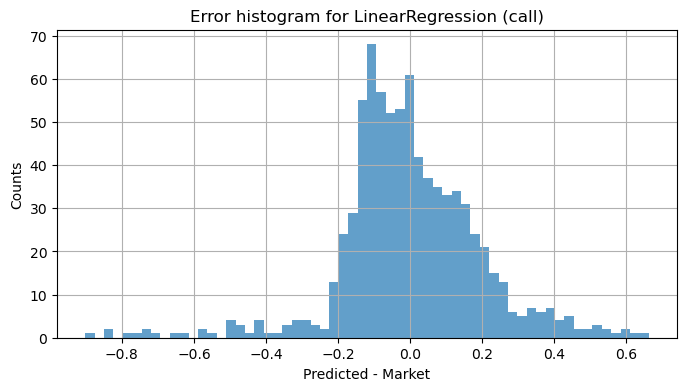

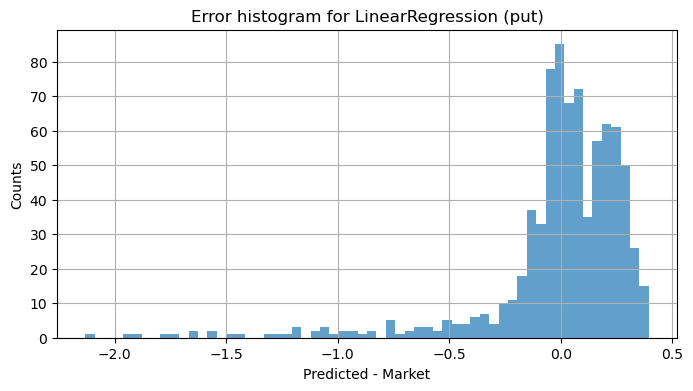

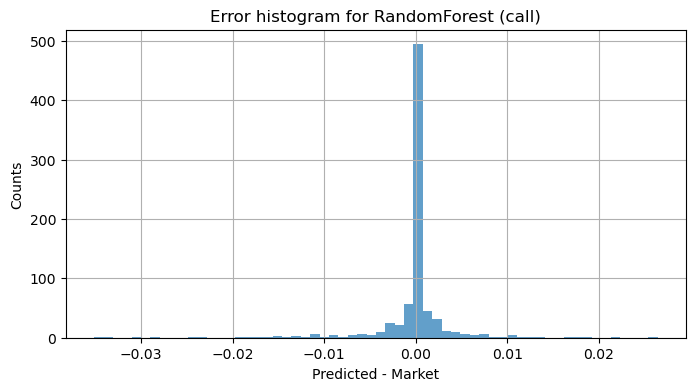

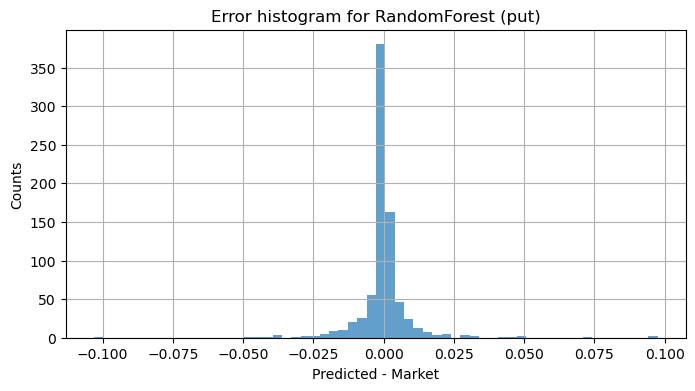

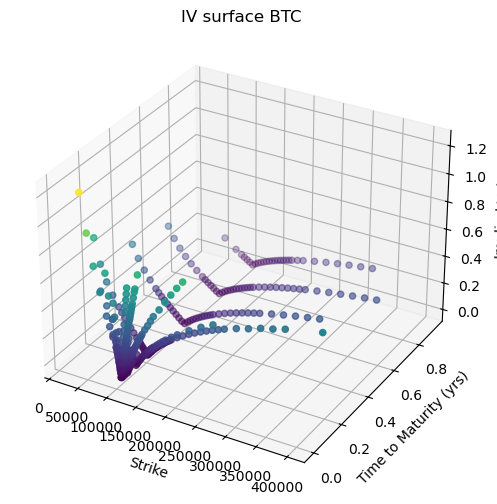

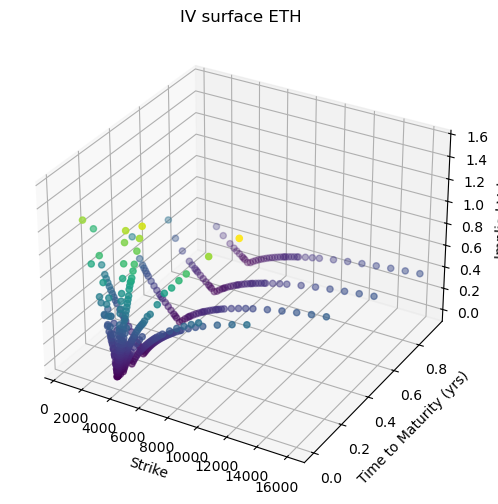

Saved model_metrics_overall.csv

Analysis guidance (auto-print):
- Check group breakdown above to see whether calls or puts are systematically over/under priced by model.
- Look for skew: if short-dated OTM options have larger errors, that suggests jumps or discrete events aren't captured well.
- Heston/Bates should reduce errors where stochastic vol & jumps are significant; Merton/Bates will help for fat-tail / jumpy underlying behavior.
- ML models should now perform better due to added theoretical features (Delta, Vega) and structural features (Moneyness, ATM/OTM). Compare ML performance against the simple BlackScholes baseline.
- Exported CSV contains overall metrics; group breakdowns are used to inspect currency x option_type patterns.


In [6]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timezone
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import math
from requests.adapters import HTTPAdapter, Retry

# ======== Requests session with retries ========
session = requests.Session()
retries = Retry(total=3, backoff_factor=0.5, status_forcelist=(429, 500, 502, 503, 504))
session.mount("https://", HTTPAdapter(max_retries=retries))

# ===================== Pricing core (unchanged + extended) =====================

def bs_price(S, K, T, r, sigma, option_type='call'):
    """Black-Scholes option price calculation."""
    if any(x is None for x in (S, K, T, r, sigma)):
        return np.nan
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan
    
    sqrt_T = math.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T
    
    if option_type.lower().startswith('c'):
        return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    else:
        return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def bs_greeks_delta_vega(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes Delta and Vega."""
    if any(x is None for x in (S, K, T, r, sigma)) or T <= 0 or sigma <= 0:
        return np.nan, np.nan
    
    sqrt_T = math.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt_T)
    
    # Delta
    if option_type.lower().startswith('c'):
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1
        
    # Vega
    vega = S * norm.pdf(d1) * sqrt_T
    
    return delta, vega


def implied_volatility(price, S, K, T, r, option_type='call', sigma_bounds=(1e-6, 5.0)):
    """Implied volatility calculation using Brent's method."""
    if any(x is None for x in (price, S, K, T, r)) or price <= 0 or S <= 0 or K <= 0 or T <= 0:
        return np.nan
    
    if option_type.lower().startswith('c'):
        intrinsic = max(0.0, S - K * math.exp(-r * T))
    else:
        intrinsic = max(0.0, K * math.exp(-r * T) - S)
        
    if price < intrinsic - 1e-12:
        return np.nan

    def f(sigma):
        return bs_price(S, K, T, r, sigma, option_type) - price

    a, b = sigma_bounds
    try:
        fa, fb = f(a), f(b)
    except Exception:
        return np.nan
    
    try:
        if fa * fb > 0:
            for factor in [2, 5, 10]:
                new_b = min(b * factor, 100.0)
                fb = f(new_b)
                if fa * fb <= 0:
                    b = new_b
                    break
            else:
                return np.nan
        iv = brentq(f, a, b, xtol=1e-8, rtol=1e-8, maxiter=200)
        if iv <= 0 or iv > 100:
            return np.nan
        return iv
    except Exception:
        return np.nan


def binomial_option_price(S, K, T, r, sigma, option_type='call', steps=200):
    """Binomial model option price calculation (European)."""
    if any(x is None for x in (S, K, T, r, sigma)):
        return np.nan
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan
    
    dt = T / steps
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp(r * dt) - d) / (u - d)
    
    j = np.arange(steps + 1)
    ST = S * (u ** (steps - j)) * (d ** j)
    
    if option_type.lower().startswith('c'):
        payoffs = np.maximum(ST - K, 0.0)
    else:
        payoffs = np.maximum(K - ST, 0.0)
        
    for _ in range(steps):
        payoffs = disc * (p * payoffs[:-1] + (1 - p) * payoffs[1:])
        
    return float(payoffs[0])


def monte_carlo_option_price(S, K, T, r, sigma, option_type='call', simulations=20000, seed=None):
    """Simple Black-Scholes Monte Carlo option price (Geometric Brownian Motion)."""
    if any(x is None for x in (S, K, T, r, sigma)):
        return np.nan
    if T <= 0 or sigma <= 0:
        return np.nan
        
    rng = np.random.default_rng(seed)
    ST = S * np.exp((r - 0.5 * sigma * sigma) * T + sigma * math.sqrt(T) * rng.standard_normal(simulations))
    
    if option_type.lower().startswith('c'):
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
        
    return float(math.exp(-r * T) * np.mean(payoff))

# Heston Monte Carlo (full-truncation Euler)
def monte_carlo_heston(S0, K, T, r, kappa=2.0, theta=0.04, xi=0.5, rho=-0.7, v0=0.04,
                       option_type='call', simulations=5000, steps=200, seed=None):
    """Monte Carlo simulation using Heston model for stochastic volatility."""
    if any(x is None for x in (S0, K, T, r)):
        return np.nan
    if T <= 0:
        return np.nan
        
    rng = np.random.default_rng(seed)
    dt = T / steps
    sqrt_dt = math.sqrt(dt)
    S = np.full(simulations, S0, dtype=np.float64)
    v = np.full(simulations, v0, dtype=np.float64)
    
    for _ in range(steps):
        z1 = rng.standard_normal(simulations)
        z2 = rng.standard_normal(simulations)
        
        dw_v = z1 * sqrt_dt
        dw_s = (rho * z1 + math.sqrt(max(0.0, 1.0 - rho * rho)) * z2) * sqrt_dt
        
        v = np.maximum(v, 0.0)
        dv = kappa * (theta - np.maximum(v, 0.0)) * dt + xi * np.sqrt(np.maximum(v, 0.0)) * dw_v
        v = v + dv
        v = np.maximum(v, 0.0)
        
        S = S * np.exp((r - 0.5 * np.maximum(v, 0.0)) * dt + np.sqrt(np.maximum(v, 0.0)) * dw_s)
        
    if option_type.lower().startswith('c'):
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
        
    return float(math.exp(-r * T) * np.mean(payoff))

# Merton jump-diffusion Monte Carlo (per-step Poisson)
def monte_carlo_merton_jump(S0, K, T, r, sigma, lam=0.1, mu_j=-0.1, sigma_j=0.2,
                            option_type='call', simulations=5000, steps=200, seed=None):
    """Monte Carlo simulation using Merton Jump-Diffusion model."""
    if any(x is None for x in (S0, K, T, r, sigma)):
        return np.nan
    if T <= 0:
        return np.nan
        
    rng = np.random.default_rng(seed)
    dt = T / steps
    S = np.full(simulations, S0, dtype=np.float64)
    kappa_j = math.exp(mu_j + 0.5 * sigma_j * sigma_j) - 1.0
    drift_adj = r - lam * kappa_j - 0.5 * sigma * sigma
    
    for _ in range(steps):
        z = rng.standard_normal(simulations)
        N = rng.poisson(lam * dt, simulations)
        jumps = np.ones(simulations, dtype=np.float64)
        idx = np.nonzero(N)[0]
        
        if idx.size > 0:
            # Only generate jumps for paths where N > 0
            for i in idx:
                Ni = int(N[i])
                zk = rng.standard_normal(Ni)
                jumps[i] = np.prod(np.exp(mu_j + sigma_j * zk))
                
        S = S * np.exp(drift_adj * dt + sigma * math.sqrt(dt) * z) * jumps
        
    if option_type.lower().startswith('c'):
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
        
    return float(math.exp(-r * T) * np.mean(payoff))

# Bates (Heston + Jumps)
def monte_carlo_bates(S0, K, T, r,
                      kappa=2.0, theta=0.04, xi=0.5, rho=-0.7, v0=0.04,
                      lam=0.1, mu_j=-0.1, sigma_j=0.2,
                      option_type='call', simulations=4000, steps=200, seed=None):
    """Monte Carlo simulation using Bates model (Heston with Jumps)."""
    if any(x is None for x in (S0, K, T, r)):
        return np.nan
    if T <= 0:
        return np.nan
        
    rng = np.random.default_rng(seed)
    dt = T / steps
    S = np.full(simulations, S0, dtype=np.float64)
    v = np.full(simulations, v0, dtype=np.float64)
    kappa_j = math.exp(mu_j + 0.5 * sigma_j * sigma_j) - 1.0
    
    for _ in range(steps):
        z1 = rng.standard_normal(simulations)
        z2 = rng.standard_normal(simulations)
        
        dw_v = z1 * math.sqrt(dt)
        dw_s = (rho * z1 + math.sqrt(max(0.0, 1.0 - rho * rho)) * z2) * math.sqrt(dt)
        
        # Heston Volatility Step (with full truncation)
        v = np.maximum(v, 0.0)
        dv = kappa * (theta - np.maximum(v, 0.0)) * dt + xi * np.sqrt(np.maximum(v, 0.0)) * dw_v
        v = v + dv
        v = np.maximum(v, 0.0)
        
        # Merton Jump Component
        N = rng.poisson(lam * dt, simulations)
        jumps = np.ones(simulations, dtype=np.float64)
        idx = np.nonzero(N)[0]
        if idx.size > 0:
            for i in idx:
                Ni = int(N[i])
                zk = rng.standard_normal(Ni)
                jumps[i] = np.prod(np.exp(mu_j + sigma_j * zk))
                
        # Stock Price Step (with Heston and Jumps)
        drift_adj = r - lam * kappa_j - 0.5 * np.maximum(v, 0.0)
        S = S * np.exp(drift_adj * dt + np.sqrt(np.maximum(v, 0.0)) * dw_s) * jumps
        
    if option_type.lower().startswith('c'):
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
        
    return float(math.exp(-r * T) * np.mean(payoff))

# ========== Simple cache for expensive pricing calls ==========
_price_cache = {}

def cached_price(func, *args, **kwargs):
    """Caches expensive model pricing calls based on input arguments."""
    key = (func.__name__,) + tuple(args) + tuple(sorted(kwargs.items()))
    if key in _price_cache:
        return _price_cache[key]
    val = func(*args, **kwargs)
    _price_cache[key] = val
    return val

# ========== Deribit API helpers (unchanged) ==========
DERIBIT_URL = "https://www.deribit.com/api/v2/public"

def safe_json_request(url, params=None, timeout=10):
    """Safely make a JSON request to a public API endpoint."""
    try:
        resp = session.get(url, params=params, timeout=timeout)
        resp.raise_for_status()
        return resp.json()
    except Exception:
        return {}


def get_index_price(currency="BTC"):
    """Fetch the index price for the underlying asset."""
    url = f"{DERIBIT_URL}/get_index"
    data = safe_json_request(url, params={"currency": currency})
    result = data.get("result") or {}
    for possible in (currency, "index_price", "price"):
        if possible in result and isinstance(result[possible], (int, float)):
            return float(result[possible])
    for v in result.values():
        if isinstance(v, (int, float)):
            return float(v)
    return np.nan


def get_option_instruments(currency="BTC"):
    """Fetch all active, unexpired option instrument names."""
    url = f"{DERIBIT_URL}/get_instruments"
    data = safe_json_request(url, params={"currency": currency, "kind": "option", "expired": "false"})
    return data.get("result", []) or []


def get_option_ticker(instrument_name):
    """Fetch the ticker (price) data for a specific instrument."""
    url = f"{DERIBIT_URL}/ticker"
    data = safe_json_request(url, params={"instrument_name": instrument_name})
    return data.get("result", {}) or {}

# ========== Fetch options data (unchanged) ==========

def fetch_options_data(currency="BTC", r=0.02, max_insts=200, sleep_between=0.06):
    """Fetches option data, spot price, and calculates implied volatility."""
    instruments = get_option_instruments(currency)
    if not instruments:
        return pd.DataFrame()
    spot = get_index_price(currency)
    rows = []
    
    for inst in instruments[:max_insts]:
        try:
            name = inst.get("instrument_name")
            strike = inst.get("strike")
            exp_ts = inst.get("expiration_timestamp")
            
            if None in (name, strike, exp_ts):
                continue
                
            exp_ts = exp_ts / 1000.0
            # Time to maturity in years
            T = (datetime.fromtimestamp(exp_ts, tz=timezone.utc) - datetime.now(timezone.utc)).total_seconds() / (365.0*24*3600)
            if T <= 0:
                continue
                
            tick = get_option_ticker(name)
            mark = tick.get("mark_price") or tick.get("last_price") or tick.get("best_bid_price") or tick.get("best_ask_price")
            
            if mark is None or mark <= 0 or np.isnan(spot):
                continue
                
            opt_type = inst.get("option_type")
            iv = implied_volatility(mark, spot, strike, T, r, opt_type)
            
            rows.append({
                "currency": currency,
                "instrument": name,
                "underlying_price": float(spot),
                "strike": float(strike),
                "time_to_maturity": float(T),
                "risk_free_rate": float(r),
                "implied_volatility": float(iv) if not np.isnan(iv) else np.nan,
                "market_price": float(mark),
                "option_type": opt_type
            })
        except Exception:
            continue
        time.sleep(sleep_between)
        
    return pd.DataFrame(rows)

# ========== DeFi / On-chain factors (best-effort) (unchanged) ==========

def fetch_defi_factors_for_df(df):
    """Add DeFi-related features where possible: gas fees for ETH, approximate Bitcoin fees, and network congestion proxies.
    These are optional features - if fetch fails, columns will be NaN and ML models will still run.
    """
    df = df.copy()
    df['gas_fee_gwei'] = np.nan
    df['btc_fee_sat_per_byte'] = np.nan
    
    # Try ETH gas price (public endpoint) - best-effort (no guarantee)
    try:
        resp = session.get('https://ethgasstation.info/json/ethgasAPI.json', timeout=6)
        data = resp.json()
        # ethgasstation returns in 10x gwei for some fields
        if 'average' in data:
            df.loc[df['currency'] == 'ETH', 'gas_fee_gwei'] = float(data['average']) / 10.0
    except Exception:
        pass
        
    # Try a public bitcoin fee API - best-effort
    try:
        resp = session.get('https://mempool.space/api/v1/fees/recommended', timeout=6)
        data = resp.json()
        if 'fastestFee' in data:
            df.loc[df['currency'] == 'BTC', 'btc_fee_sat_per_byte'] = float(data['fastestFee'])
    except Exception:
        pass
        
    # Fill small defaults for plotting convenience (do NOT use for pricing) if still NaN
    df['gas_fee_gwei'] = df['gas_fee_gwei'].fillna(method='ffill').fillna(np.nan)
    df['btc_fee_sat_per_byte'] = df['btc_fee_sat_per_byte'].fillna(method='ffill').fillna(np.nan)
    
    return df

# ========== NEW: Feature Engineering Function ==========

def add_feature_engineering(df):
    """
    Creates structural, theoretical, and statistical features for Machine Learning models.
    """
    print("\n🔨 [add_feature_engineering] Creating advanced features...")
    df_new = df.copy()

    # 1. Structural Features (Moneyness)
    # Moneyness: ln(S/K)
    df_new['moneyness'] = np.log(df_new['underlying_price'] / df_new['strike'])

    # 2. Time Features
    # Square Root Time: sqrt(T)
    df_new['sqrt_time_to_maturity'] = np.sqrt(df_new['time_to_maturity'])

    # 3. Option Type Encoding
    # Call=1, Put=0 (Standard ML encoding for categorical features)
    df_new['option_type_is_call'] = (df_new['option_type'].str.lower() == 'call').astype(int)

    # 4. Black-Scholes Greeks (Theoretical Features) - using implied vol
    
    # Calculate Delta and Vega based on the implied volatility (IV)
    greeks = df_new.apply(
        lambda r: bs_greeks_delta_vega(
            r['underlying_price'], r['strike'], r['time_to_maturity'], 
            r['risk_free_rate'], r['implied_volatility'], r['option_type']
        ), axis=1, result_type='expand'
    )
    greeks.columns = ['bs_delta', 'bs_vega']
    df_new = pd.concat([df_new, greeks], axis=1)

    # 5. Moneyness Region Flags
    # The Black-Scholes model price (BS_price) is used as a proxy for fair value
    # to determine in/out/at the money classification (based on current IV)
    
    # Intrinsic Value (IV) for call: max(0, S - K)
    # Intrinsic Value (IV) for put: max(0, K - S)
    df_new['intrinsic_value'] = df_new.apply(
        lambda r: max(0, r['underlying_price'] - r['strike']) if r['option_type_is_call'] else max(0, r['strike'] - r['underlying_price']), axis=1
    )
    
    # Time Value (TV) is Market Price - Intrinsic Value
    df_new['time_value'] = df_new['market_price'] - df_new['intrinsic_value']
    
    # Simple At-The-Money (ATM) region: abs(S - K) / S < 0.05
    threshold = 0.03 # 3% deviation
    df_new['is_atm'] = (np.abs(df_new['underlying_price'] - df_new['strike']) / df_new['underlying_price'] < threshold).astype(int)
    
    # In-The-Money (ITM) and Out-Of-The-Money (OTM)
    df_new['is_itm'] = np.where(
        df_new['option_type_is_call'] == 1, 
        df_new['underlying_price'] > df_new['strike'], 
        df_new['underlying_price'] < df_new['strike']
    ).astype(int)
    
    df_new['is_otm'] = 1 - df_new['is_itm'] # OTM is not ITM
    
    # Remove the simple OTM/ITM flags if it's ATM to avoid multicollinearity issues
    df_new.loc[df_new['is_atm'] == 1, ['is_itm', 'is_otm']] = 0

    print("✅ Feature engineering complete.")
    return df_new

# ========== Add model prices (for both calls and puts) (unchanged) ==========

def add_traditional_models(df,
                          mc_sims_standard=8000,
                          mc_sims_heston=4000,
                          mc_sims_merton=4000,
                          mc_sims_bates=3000,
                          mc_steps=150):
    """Adds traditional option pricing model results to the DataFrame."""
    df = df.copy()
    df[['underlying_price','strike','time_to_maturity','risk_free_rate','implied_volatility']] = \
        df[['underlying_price','strike','time_to_maturity','risk_free_rate','implied_volatility']].apply(pd.to_numeric, errors='coerce')

    # Native BS (uses implied vol as input)
    df['BS_price'] = df.apply(lambda r: bs_price(r['underlying_price'], r['strike'], r['time_to_maturity'], r['risk_free_rate'], r['implied_volatility'], r['option_type']), axis=1)
    df['Binomial_price'] = df.apply(lambda r: cached_price(binomial_option_price, r['underlying_price'], r['strike'], r['time_to_maturity'], r['risk_free_rate'], r['implied_volatility'], r['option_type'], 100), axis=1)
    df['MonteCarlo_price'] = df.apply(lambda r: cached_price(monte_carlo_option_price, r['underlying_price'], r['strike'], r['time_to_maturity'], r['risk_free_rate'], r['implied_volatility'], r['option_type'], mc_sims_standard, None), axis=1)

    # Heston (placeholder params)
    def heston_row(r):
        return cached_price(monte_carlo_heston,
                            r['underlying_price'], r['strike'], r['time_to_maturity'], r['risk_free_rate'],
                            2.0, 0.04, 0.5, -0.7, 0.04, # Placeholder Heston params
                            r['option_type'], mc_sims_heston, mc_steps, None)
    df['Heston_price'] = df.apply(lambda r: heston_row(r), axis=1)

    # Merton jump-diffusion
    def merton_row(r):
        return cached_price(monte_carlo_merton_jump,
                            r['underlying_price'], r['strike'], r['time_to_maturity'], r['risk_free_rate'], r['implied_volatility'],
                            0.25, -0.05, 0.3, r['option_type'], mc_sims_merton, mc_steps, None) # Placeholder Merton params
    df['Merton_price'] = df.apply(lambda r: merton_row(r), axis=1)

    # Bates (Heston + jumps)
    def bates_row(r):
        return cached_price(monte_carlo_bates,
                            r['underlying_price'], r['strike'], r['time_to_maturity'], r['risk_free_rate'],
                            2.0, 0.04, 0.5, -0.7, 0.04, # Placeholder Heston params
                            0.12, -0.06, 0.28, r['option_type'], mc_sims_bates, mc_steps, None) # Placeholder Jump params
    df['Bates_price'] = df.apply(lambda r: bates_row(r), axis=1)

    return df

# ========== ML training helpers (UPDATED feature list) ==========

def train_ml_models(df):
    
    try:
        from xgboost import XGBRegressor
        has_xgb = True
    except ImportError:
        has_xgb = False

    print("\n🔧 [train_ml_models] Starting model training...")

    # UPDATED: Added new engineered features and BSM price/greeks
    candidate_features = [
        # Core Inputs
        'underlying_price', 'strike', 'time_to_maturity', 'risk_free_rate', 'implied_volatility',
        'option_type_is_call', 
        # Engineered Features
        'moneyness', 'sqrt_time_to_maturity', 'bs_delta', 'bs_vega',
        'is_atm', 'is_itm', 'is_otm',
        # DeFi Features
        'gas_fee_gwei', 'btc_fee_sat_per_byte', 
        # Theoretical Price (as a baseline feature - optional but often powerful)
        'BS_price'
    ]

    # Use only columns that actually exist and are not the target
    target = 'market_price'
    features = [c for c in candidate_features if c in df.columns and c != target]
    if not features:
        raise ValueError("No valid feature columns found in the dataframe!")

    dfc = df.copy().dropna(subset=[target]) # Ensure target is not NaN
    
    print(f"✅ Using features: {features}")
    print(f"🎯 Target: {target}")

    # Impute missing values (DeFi features, IV for failed IV calc, Greeks for failed IV calc)
    imp = SimpleImputer(strategy='mean')
    X = imp.fit_transform(dfc[features])
    y = dfc[target].values

    if np.isnan(X).any() or np.isnan(y).any():
        raise ValueError("Imputation failed — still found NaN in X or y")

    print(f"✅ Imputation complete: X shape={X.shape}, y length={len(y)}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    }
    if has_xgb:
        models['XGBoost'] = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

    preds = {}
    metrics = {}

    for name, m in models.items():
        print(f"🚀 Training {name} ...")
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        metrics[name] = {'MAE': mae, 'RMSE': rmse}

        # Predict on the entire dataset for plotting/full evaluation later
        preds[name] = m.predict(imp.transform(dfc[features]))

        print(f"   → {name} done. MAE={mae:.4f}, RMSE={rmse:.4f}")

    metrics_df = pd.DataFrame(metrics).T
    print("\n📊 ML model performance on Test Set:")
    print(metrics_df)

    return preds

# ========== Evaluation helpers (unchanged) ==========

def evaluate_predictions(df, pred_cols):
    """Compute MAE/RMSE for a dict of predictions or series. pred_cols is dict name->array/series
    Returns dict of metrics and also attaches predictions to df as columns named after keys.
    """
    metrics = {}
    df = df.copy()
    for name, vals in pred_cols.items():
        col = f'pred_{name}'
        
        # Ensure 'vals' is an array of the correct length, or map back to indices if needed
        # Since train_ml_models predicts on the entire filtered/imputed dataframe, 
        # we need to map back to the original index. This assumes the pred array matches dfc order.
        if len(vals) == len(df.dropna(subset=['market_price'])):
            df.loc[df.dropna(subset=['market_price']).index, col] = vals
        elif len(vals) == len(df):
             df[col] = vals
        else:
            print(f"Warning: Prediction length mismatch for {name}. Skipping attachment.")
            continue
            
        tmp = df[['market_price', col, 'currency', 'option_type']].dropna()
        overall = {'MAE': np.nan, 'RMSE': np.nan}
        if not tmp.empty:
            overall['MAE'] = float(mean_absolute_error(tmp['market_price'], tmp[col]))
            overall['RMSE'] = float(np.sqrt(mean_squared_error(tmp['market_price'], tmp[col])))
        
        # by currency & option_type
        grouped = tmp.groupby(['currency','option_type']).apply(lambda g: pd.Series({'MAE': mean_absolute_error(g['market_price'], g[col]), 'RMSE': np.sqrt(mean_squared_error(g['market_price'], g[col]))})) if not tmp.empty else pd.DataFrame()
        metrics[name] = {'overall': overall, 'by_group': grouped}
        
    return metrics, df

# Pretty print metrics
def print_metrics_summary(metrics):
    rows = []
    for name, info in metrics.items():
        ov = info['overall']
        rows.append((name, ov.get('MAE', np.nan), ov.get('RMSE', np.nan)))
    tab = pd.DataFrame(rows, columns=['Model', 'MAE', 'RMSE']).set_index('Model')
    print('\nOverall Metrics (Full Dataset)')
    print(tab)

    # group breakdowns
    for name, info in metrics.items():
        print(f"\n{name} group breakdown (currency x option_type):")
        if isinstance(info['by_group'], pd.DataFrame) and not info['by_group'].empty:
            print(info['by_group'])
        else:
            print('No grouped data available for', name)

# ========== Plotting helpers (unchanged) ==========

def plot_rmse_mae_trends(metrics_dict, title_prefix=''):
    models = list(metrics_dict.keys())
    maes = [metrics_dict[m]['overall']['MAE'] for m in models]
    rmses = [metrics_dict[m]['overall']['RMSE'] for m in models]

    x = np.arange(len(models))
    plt.figure(figsize=(10,5))
    plt.plot(x, maes, marker='o', label='MAE')
    plt.plot(x, rmses, marker='s', label='RMSE')
    plt.xticks(x, models, rotation=45)
    plt.title(f'{title_prefix} MAE & RMSE across models')
    plt.ylabel('Error')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_errors_by_option_type(df, pred_col_prefix='pred_'):
    # separate call & put errors for each model
    for col in df.columns:
        if col.startswith(pred_col_prefix):
            model = col[len(pred_col_prefix):]
            tmp = df.dropna(subset=[col,'market_price','option_type','currency'])
            if tmp.empty:
                continue
            tmp['error'] = tmp[col] - tmp['market_price']
            for ot in ['call','put']:
                sub = tmp[tmp['option_type'].str.lower()==ot]
                if sub.empty:
                    continue
                plt.figure(figsize=(8,4))
                plt.hist(sub['error'], bins=60, alpha=0.7)
                plt.title(f'Error histogram for {model} ({ot})')
                plt.xlabel('Predicted - Market')
                plt.ylabel('Counts')
                plt.grid(True)
                plt.show()


def plot_pred_vs_market(df, pred_col, title=None):
    tmp = df.dropna(subset=[pred_col,'market_price'])
    if tmp.empty:
        return
    plt.figure(figsize=(6,6))
    plt.scatter(tmp['market_price'], tmp[pred_col], s=8, alpha=0.6)
    mx = max(tmp['market_price'].max(), tmp[pred_col].max())
    plt.plot([0,mx],[0,mx], linestyle='--')
    plt.xlabel('Market Price')
    plt.ylabel(pred_col)
    plt.title(title or f'{pred_col} vs Market')
    plt.grid(True)
    plt.show()

# IV surface (per currency)
def plot_iv_surface(df, currency, annotate=False):
    d = df[df['currency']==currency].dropna(subset=['implied_volatility','strike','time_to_maturity'])
    if d.empty:
        return
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(d['strike'], d['time_to_maturity'], d['implied_volatility'], c=d['implied_volatility'], cmap="viridis")
    ax.set_xlabel('Strike')
    ax.set_ylabel('Time to Maturity (yrs)')
    ax.set_zlabel('Implied Vol')
    ax.set_title(f'IV surface {currency}')
    plt.show()


# ========== Main workflow (UPDATED) ==========

def main():
    btc = fetch_options_data('BTC', max_insts=1500)
    eth = fetch_options_data('ETH', max_insts=1500)
    
    if btc.empty and eth.empty:
        print('No data fetched. Check network / API or increase max_insts')
        return
        
    df = pd.concat([btc, eth], ignore_index=True)
    df = df.dropna(subset=['underlying_price','strike','time_to_maturity','market_price'])
    print(f'Loaded {len(df)} option rows (calls+puts total).')

    # Add DeFi features (best-effort)
    df = fetch_defi_factors_for_df(df)

    # Add traditional models (necessary for BS_price feature in ML)
    df = add_traditional_models(df,
                                mc_sims_standard=6000,
                                mc_sims_heston=3000,
                                mc_sims_merton=3000,
                                mc_sims_bates=2500,
                                mc_steps=120)

    # NEW: Add Feature Engineering
    df = add_feature_engineering(df)
    
    # Prepare predictions dict (traditional):
    preds_trad = {
        'BlackScholes': df['BS_price'].values,
        'Binomial': df['Binomial_price'].values,
        'MonteCarlo': df['MonteCarlo_price'].values,
        'Heston': df['Heston_price'].values,
        'Merton': df['Merton_price'].values,
        'Bates': df['Bates_price'].values
    }

    metrics_trad, df_with_preds = evaluate_predictions(df, preds_trad)
    print_metrics_summary(metrics_trad)
    plot_rmse_mae_trends(metrics_trad, title_prefix='Traditional')

    # ML
    # We must only train ML on rows where market_price is known, and feature engineering was successful
    df_ml_input = df_with_preds.copy().dropna(subset=['market_price'])
    
    preds_ml_raw = train_ml_models(df_ml_input)
    
    # Map predictions back to the original index for evaluation
    preds_ml = {}
    for name, pred_arr in preds_ml_raw.items():
        full_pred = np.full(len(df_with_preds), np.nan)
        # Use the index of the dataframe used for training (df_ml_input) to place predictions
        full_pred[df_ml_input.index] = pred_arr
        preds_ml[name] = full_pred

    if preds_ml:
        metrics_ml, df_with_preds = evaluate_predictions(df_with_preds, preds_ml)
        print_metrics_summary(metrics_ml)
        plot_rmse_mae_trends(metrics_ml, title_prefix='ML')
    else:
        metrics_ml = {}
        print('\nNot enough data to train ML models or missing features. Skipping ML evaluation.')

    # Combine metrics for cross-model trend plotting
    all_metrics = {**metrics_trad}
    for k, v in metrics_ml.items():
        all_metrics[f'ML_{k}'] = v

    plot_rmse_mae_trends(all_metrics, title_prefix='All Models')

    # Plot predicted vs market and call/put errors
    all_pred_cols = {**preds_trad, **{f'ML_{k}': v for k, v in preds_ml.items()}}
    for name in all_pred_cols.keys():
        col = f'pred_{name}'
        # Ensure the column exists before plotting
        if col in df_with_preds.columns:
            plot_pred_vs_market(df_with_preds, col, title=f'{name} Pred vs Market')

    # Separate call & put error histograms per model
    plot_errors_by_option_type(df_with_preds, pred_col_prefix='pred_')

    # IV surfaces
    for c in df_with_preds['currency'].unique():
        plot_iv_surface(df_with_preds, c)

    # Save summary tables
    try:
        metrics_overall = []
        for k, v in all_metrics.items():
            metrics_overall.append({'model': k, 'MAE': v['overall']['MAE'], 'RMSE': v['overall']['RMSE']})
        pd.DataFrame(metrics_overall).to_csv('model_metrics_overall.csv', index=False)
        print('Saved model_metrics_overall.csv')
    except Exception:
        pass

    # Error pattern discussion guidance (printed):

    # Error pattern discussion guidance (printed):
    print('\nAnalysis guidance (auto-print):')
    print('- Check group breakdown above to see whether calls or puts are systematically over/under priced by model.')
    print("- Look for skew: if short-dated OTM options have larger errors, that suggests jumps or discrete events aren't captured well.")
    print("- Heston/Bates should reduce errors where stochastic vol & jumps are significant; Merton/Bates will help for fat-tail / jumpy underlying behavior.")
    print("- ML models should now perform better due to added theoretical features (Delta, Vega) and structural features (Moneyness, ATM/OTM). Compare ML performance against the simple BlackScholes baseline.")
    print("- Exported CSV contains overall metrics; group breakdowns are used to inspect currency x option_type patterns.")

if __name__ == '__main__':
    main()
   


In [9]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# --- 1. Black-Scholes Implementation (Complete) ---

def black_scholes(S, K, T, r, sigma, option_type):
    # Set dividend yield q=0
    q = 0.0

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate Price
    if option_type == 'Call':
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'Put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        price = np.nan
        
    return price

# --- 2. Binomial Option Pricing Model (BOPM) Setup (Partial) ---

# Note: Full N-step BOPM is complex for this script, but the core function is defined.
def bopm_price_at_t0(S, K, T, r, sigma, option_type, N=100):
    """
    Placeholder for the Binomial Option Pricing Model.
    Requires implementation of the binomial tree generation.
    """
    # ... implementation for u, d, p, and backward induction ...
    # This would involve creating the N steps for the tree.
    return 0.0 # Returns 0.0 as a placeholder for the price at time t=0

# --- 3. Monte Carlo Simulation (MCS) Setup (Partial) ---

# Note: Full MCS involves simulating many paths, which is computationally intensive.
def monte_carlo_price(S, K, T, r, sigma, option_type, n_sims=10000):
    """
    Placeholder for Monte Carlo Simulation Pricing.
    Requires implementation of geometric Brownian motion.
    """
    # dt = T / 1
    # z = np.random.standard_normal(n_sims)
    # St = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    # ...
    return 0.0 # Returns 0.0 as a placeholder for the price

# --- 4. Machine Learning Model Setup ---

def train_ml_model(df):
    
    # Drop rows where mark_price is zero or near-zero as it causes division by zero issues
    # and often represents highly illiquid/expired options.
    df_ml = df[df['mark_price'] > 0.0001].copy()

    # Create dummy variables for Option Type (ML models need numeric input)
    df_ml['is_call'] = (df_ml['Option Type'] == 'Call').astype(int)
    
    # Select features (X) and target (y)
    # S, K, T, sigma_annual, is_call are the standard inputs.
    features = ['underlying_price', 'Strike Price', 'Time to Expiration', 'sigma_annual', 'is_call']
    X = df_ml[features]
    y = df_ml['mark_price']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train a simple Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("\n--- Machine Learning Model (Linear Regression) ---")
    print(f"Features: {features}")
    print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}")
    
    # Show feature coefficients
    coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
    print("\nModel Coefficients:")
    print(coefficients.to_markdown(index=False, numalign='left', stralign='left'))


# --- EXECUTION ---
# Load the data
df = pd.read_csv("data.csv")

# Set the assumed risk-free rate (r=2.5% annualized)
RISK_FREE_RATE = 0.025

# Prepare Volatility (mark_iv is percentage -> convert to decimal)
df['sigma_annual'] = df['mark_iv'] / 100.0

# Calculate Black-Scholes Price
df['bs_price'] = df.apply(
    lambda row: black_scholes(
        S=row['underlying_price'],
        K=row['Strike Price'],
        T=row['Time to Expiration'],
        r=RISK_FREE_RATE,
        sigma=row['sigma_annual'],
        option_type=row['Option Type']
    ),
    axis=1
)
df['bs_price_residual'] = df['mark_price'] - df['bs_price']

print("\n--- Black-Scholes Analysis Complete ---")
print(f"Mean Absolute Error (MAE) for Black-Scholes: {df['bs_price_residual'].abs().mean():.4f}")

# Run the Machine Learning Analysis
train_ml_model(df)


--- Black-Scholes Analysis Complete ---
Mean Absolute Error (MAE) for Black-Scholes: 2686.1570

--- Machine Learning Model (Linear Regression) ---
Features: ['underlying_price', 'Strike Price', 'Time to Expiration', 'sigma_annual', 'is_call']
Root Mean Squared Error (RMSE) on Test Set: 0.0267

Model Coefficients:
| Feature            | Coefficient   |
|:-------------------|:--------------|
| underlying_price   | -0.0030714    |
| Strike Price       | 1.92111e-06   |
| Time to Expiration | 45.5978       |
| sigma_annual       | 0.336136      |
| is_call            | 0.00097181    |
